In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    if i >= iter_max:
        raise Error("No convergence")
    return a

In [2]:
# Household heterogeneous block
def consumption(c, we, rest, gamma, nu, phi):
    return c - we * (we / (phi * c ** gamma)) ** (1/nu) - rest

def household_guess(a_grid, e_grid, r, w, gamma, T):
    wel = (1 + r) * a_grid[np.newaxis,:] + w * e_grid[:,np.newaxis] + T[:,np.newaxis]
    V_prime = (1 + r) * (wel * 0.1) ** (-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p, a_grid, e_grid, r, w, T, beta, gamma, nu, phi):

    we = w * e_grid
    c_prime = (beta * V_prime_p) ** (-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t
    n_prime = (we[:,np.newaxis] / (phi * c_prime ** gamma)) ** (1/nu)
    new_grid = (c_prime + a_grid[np.newaxis,:] - we[:,np.newaxis] * n_prime - T[:,np.newaxis])
    wel = (1 + r) * a_grid
    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)
    a = wel + we[:,np.newaxis] * n + T[:,np.newaxis] - c
    V_prime = (1 + r) * c ** (-gamma)

    # Check for violation of the asset constraint and fix it
    indexes_asset = np.nonzero(a < a_grid[0]) # first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        aa = np.zeros((indexes_asset[0].size)) + 1E-5
        rest = -a_grid[0] + wel[indexes_asset[1]] + T[indexes_asset[0]]
        bb = c[indexes_asset] + 0.5
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,nu,phi),aa,bb)
        n[indexes_asset] = (we[indexes_asset[0]] / (phi * c[indexes_asset] ** gamma)) ** (1/nu)
        V_prime[indexes_asset] = (1 + r) * (c[indexes_asset]) ** (-gamma)
    return V_prime, a, c, n

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE) # pi_e is stationary distribution, Pi is transition matrix
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    transfer_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer = Transfer / np.sum(pi_e * transfer_rule) * transfer_rule
    T = div + transfer
    return T

household_inp = household.add_hetinputs([make_grid,transfers])

def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

hh_ext = household_inp.add_hetoutputs([labor_supply])

print(hh_ext)
print(f'Outputs: {hh_ext.outputs}')
print(f'Inputs: {household_inp.inputs}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'T', 'beta', 'gamma', 'nu', 'phi', 'Pi']
Macro outputs: ['A', 'C', 'N']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'n']
<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Outputs: ['A', 'C', 'N', 'NE']
Inputs: ['r', 'w', 'beta', 'gamma', 'nu', 'phi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']


In [3]:
# Simple blocks
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return L, Div

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    i = rstar
    return r, i

@simple
def fiscal(r, B):
    Transfer = - r * B
    return Transfer

@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

blocks_ss = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'nu', 'phi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B']


In [4]:
calibration = {'gamma': 1.0, 'nu': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5, 'B': 6.0}

unknowns_ss = {'beta': 0.986, 'phi': 0.8}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver = "hybr")

In [5]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name = "One-Asset HANK")
#print(*hank.blocks, sep = '\n')

ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))
    
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
#print(G)

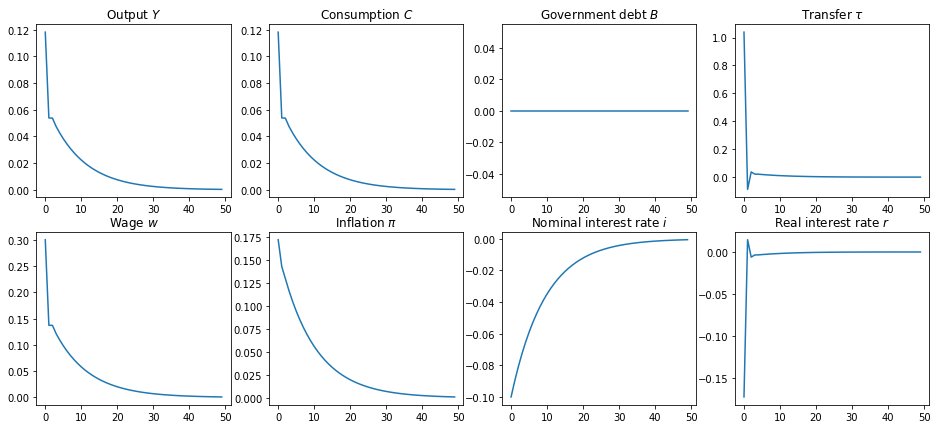

----------------------------------------------------------------------
PARAMETERS
Discount factor            0.988   Intertemporal elasticity      1.000
Labor supply elasticity    0.500   Labor disutility              0.856
Goods substitutability     6.000   Price markup                  1.200
Phillips curve slope       0.100   Taylor inflation              1.500

VARIABLES IN STEADY STATE
Output                     1.000   Government debt               6.000
Consumption                1.000   Transfers                    -0.030
Hours                      0.976   Dividends                     0.167
Wage                       0.833   Marginal cost                 0.833
Inflation                  0.000   Nominal interest rate         0.005
Real interest rate         0.005   Debt servicing  cost          0.030

MARKET CLEARING
Bond market                -3e-14  Labor market                  3e-15
Goods market (resid)       -5e-09                                  nan
----------------------

In [6]:
# Impulse response functions
rhos = 0.9
drstar = -0.1 * rhos ** (np.arange(T)[:, np.newaxis])

dY = G['Y']['rstar'] @ drstar
dC = G['C']['rstar'] @ drstar
dN = G['N']['rstar'] @ drstar
dB = G['A']['rstar'] @ drstar
dw = G['w']['rstar'] @ drstar
dp = G['pi']['rstar'] @ drstar
dr = G['r']['rstar'] @ drstar
dd = G['Div']['rstar'] @ drstar
dT = G['Transfer']['rstar'] @ drstar
di = G['i']['rstar'] @ drstar

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)

ax[0, 0].set_title(r'Output $Y$')
ax[0, 0].plot(dY[:50, :])

ax[0, 1].set_title(r'Consumption $C$')
ax[0, 1].plot(dC[:50, :])

ax[0, 2].set_title(r'Government debt $B$')
ax[0, 2].plot(np.around(dB[:50, :], decimals = 4) * ss0['A'])

ax[0, 3].set_title(r'Transfer $\tau$')
ax[0, 3].plot(dT[:50, :])

ax[1, 0].set_title(r'Wage $w$')
ax[1, 0].plot(dw[:50, :])

ax[1, 1].set_title(r'Inflation $\pi$')
ax[1, 1].plot(dp[:50, :])

ax[1, 2].set_title(r'Nominal interest rate $i$')
ax[1, 2].plot(di[:50, :])

ax[1, 3].set_title(r'Real interest rate $r$')
ax[1, 3].plot(dr[:50, :])
plt.show()

# Show steady state
ss_param = [['Discount factor', ss0['beta'], 'Intertemporal elasticity', ss0['gamma']],
        ['Labor supply elasticity', 1 / ss0['nu'], 'Labor disutility', ss0['phi']],  
        ['Goods substitutability', ss0['mu'] / (ss0['mu'] - 1), 'Price markup', ss0['mu']],
        ['Phillips curve slope', ss0['kappa'], 'Taylor inflation ', ss0['phi_pi']]]

ss_var = [['Output', ss0['Y'], 'Government debt', ss0['A']],
        ['Consumption', ss0['C'], 'Transfers', ss0['Transfer']],
        ['Hours', ss0['N'], 'Dividends', ss0['Div']], 
        ['Wage', ss0['w'], 'Marginal cost', ss0['w'] / ss0['Z']],
        ['Inflation', ss0['pi'], 'Nominal interest rate', ss0['r']*(1+ss0['pi'])],
        ['Real interest rate', ss0['r'], 'Debt servicing  cost', ss0['r'] * ss0['A']]]
ss_mkt = [['Bond market', ss0['asset_mkt'], 'Labor market', ss0['labor_mkt']],
          ['Goods market (resid)', ss0['goods_mkt'], '', float('nan')]]

dash = '-' * 70
print(dash)
print('PARAMETERS')
for i in range(len(ss_param)):
      print('{:25s}{:^10.3f}{:25s}{:>10.3f}'.format(ss_param[i][0],ss_param[i][1],ss_param[i][2],ss_param[i][3]))
print('\nVARIABLES IN STEADY STATE')
for i in range(len(ss_var)):
      print('{:25s}{:^10.3f}{:25s}{:>10.3f}'.format(ss_var[i][0],ss_var[i][1],ss_var[i][2],ss_var[i][3]))
print('\nMARKET CLEARING')
for i in range(len(ss_mkt)):
      print('{:25s}{:^10.0e}{:25s}{:>10.0e}'.format(ss_mkt[i][0],ss_mkt[i][1],ss_mkt[i][2],ss_mkt[i][3]))
print(dash)